In [1]:
import os, sys
import numpy as np
import geopandas as gpd
import plotly.express as px
sys.path.append('../')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from onsstove.onsstove import OnSSTOVE, DataProcessor
from onsstove.layer import RasterLayer, VectorLayer
from onsstove.raster import interpolate
import time

# Data processing

## 1. Create a data processor

In [4]:
start = time.time()

data = DataProcessor(project_crs=3857, cell_size=(1000, 1000))
output_directory = 'results'
data.output_directory = output_directory

## 2. Add a mask layer (country boundaries)

In [5]:
adm_path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\NPL_adm0_Nepal0.shp"
data.add_mask_layer(category='Administrative', name='Country_boundaries', layer_path=adm_path)

## 3. Add GIS layers

### Demographics

In [6]:
pop_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Population\HRSL\population_npl_2018-10-01_geotiff\population_npl_2018-10-01.tif"
data.add_layer(category='Demographics', name='Population', layer_path=pop_path, layer_type='raster', base_layer=True, resample='sum')

# Check if this is needed for a general implementation
# data.layers['Demographics']['Population'].layer[np.isnan(data.layers['Demographics']['Population'].layer)] = 0
# data.layers['Demographics']['Population'].save(os.path.join(data.output_directory, 'Demographics', 'Population'))

ghs_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Urban - Rural divide\GHS.tif"
data.add_layer(category='Demographics', name='Urban_rural_divide', layer_path=ghs_path, layer_type='raster', resample='nearest')

### Biomass

In [7]:
forest_path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Forest cover\Forest_cover_2020.tif"
data.add_layer(category='Biomass', name='Forest', layer_path=forest_path, layer_type='raster', resample='average')

friction_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Walking friction\2020_walking_only_friction_surface.geotiff"
data.add_layer(category='Biomass', name='Friction', layer_path=friction_path, layer_type='raster', resample='average', window=True)

### Electricity

In [8]:
hv_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\HV-network\Existing_transmission_lines.geojson"
data.add_layer(category='Electricity', name='HV_lines', layer_path=hv_path, layer_type='vector')

mv_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MV-network\Nepal_DL0.shp"
data.add_layer(category='Electricity', name='MV_lines', layer_path=mv_path, layer_type='vector')

ntl_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Night Time Lights\nighttime lights.tif"
data.add_layer(category='Electricity', name='Night_time_lights', layer_path=ntl_path, layer_type='raster', resample='average')

### LPG

In [9]:
lpg_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\LPG\Nepal_Gas_12Jun2021_Final4.shp"
data.add_layer(category='LPG', name='Suppliers', layer_path=lpg_path, layer_type='vector')

friction_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Motorized friction\2020_motorized_friction_surface.geotiff"
data.add_layer(category='LPG', name='Friction', layer_path=friction_path, layer_type='raster', resample='average', window=True)

### Biogas

In [10]:
temperature = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Temperature\TEMP.tif"
data.add_layer(category='Biogas', name='Temperature', layer_path=temperature,
               layer_type='raster', resample='average', window=True)
data.layers['Biogas']['Temperature'].save(f'{data.output_directory}/Biogas/Temperature')

## 4. Mask reproject and align all required layers

In [11]:
data.mask_layers(datasets={'Demographics': ['Population', 'Urban_rural_divide'],
                           'Biomass': ['Forest', 'Friction'],
                           'Electricity': ['HV_lines', 'Night_time_lights'],
                           'LPG': ['Suppliers', 'Friction'],
                           'Biogas': ['Temperature']})

In [12]:
data.align_layers(datasets='all')

In [13]:
data.reproject_layers(datasets={'Electricity': ['HV_lines', 'MV_lines'],
                                'LPG': ['Suppliers']})

In [14]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

Execution time: 0 min 31 sec


# Model preparation

## 1. Create an OnSSTOVE model

In [15]:
start = time.time()

nepal = OnSSTOVE()
output_directory = 'results'
nepal.output_directory = output_directory

## 2. Read the model data

In [16]:
path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\OnSSTOVE cases\NP_test_file_social_specs.csv"
nepal.read_scenario_data(path, delimiter=',')

## 3. Add a country mask layer

In [17]:
path = os.path.join(output_directory, 'Administrative', 'Country_boundaries', 'Country_boundaries.geojson')
mask_layer = VectorLayer('admin', 'adm_0', layer_path=path)
nepal.mask_layer = mask_layer

## 4. Add a population base layer

In [18]:
path = os.path.join(output_directory, 'Demographics', 'Population', 'Population.tif')
nepal.add_layer(category='Demographics', name='Population', layer_path=path, layer_type='raster', base_layer=True)
nepal.population_to_dataframe()

In [19]:
# path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\Admin lvl 1.shp"
# nepal.add_admin_names(path, 'ADM1_EN')

## 5. Calibrate population and urban/rural split

In [20]:
nepal.calibrate_current_pop()

# path = os.path.join(output_directory, 'Demographics', 'Urban_rural_divide', 'Urban_rural_divide.tif')
ghs_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Urban - Rural divide\GHS.tif"
nepal.calibrate_urban_current_and_future_GHS(ghs_path)

## 6. Add wealth index GIS data

In [21]:
wealth_index = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Wealth Index\npl_relative_wealth_index.csv"
nepal.extract_wealth_index(wealth_index, file_type="csv", 
                           x_column="longitude", y_column="latitude", wealth_column="rwi")

# wealth_index = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Wealth Index\Wealth index 2011.tif"
# nepal.extract_wealth_index(wealth_index, file_type="raster")

## 7. Calculate value of time

In [22]:
# Based on wealth index, minimum wage and a lower an upper range for cost of oportunity
nepal.get_value_of_time()

## 8. Read electricity network GIS layers

In [23]:
# Read MV lines
path = os.path.join(output_directory, 'Electricity', 'MV_lines', 'MV_lines.geojson')
mv_lines = VectorLayer('Electricity', 'MV_lines', layer_path=path)

# Read HV lines
path = os.path.join(output_directory, 'Electricity', 'HV_lines', 'HV_lines.geojson')
hv_lines = VectorLayer('Electricity', 'HV_lines', layer_path=path)

### 8.1. Calculate distance to electricity infrastructure 

In [24]:
nepal.distance_to_electricity(hv_lines=hv_lines, mv_lines=mv_lines)

### 8.2. Add night time lights data

In [25]:
path = os.path.join(output_directory, 'Electricity', 'Night_time_lights', 'Night_time_lights.tif')
ntl = RasterLayer('Electricity', 'Night_time_lights', layer_path=path)

nepal.raster_to_dataframe(ntl.layer, name='Night_lights', method='read')

## 9. Calibrate current electrified population

In [26]:
nepal.current_elec()
nepal.final_elec()

print('Calibrated grid electrified population fraction:', nepal.gdf['Elec_pop_calib'].sum() / nepal.gdf['Calibrated_pop'].sum())

Calibrated grid electrified population fraction: 0.7197726968187167


## 10. Read the cooking technologies data

In [27]:
path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\OnSSTOVE cases\NP_test_file_tech_specs.csv"
nepal.read_tech_data(path, delimiter=',')

## 11. Calculate parameters of base fuel (Biomass)

### 11.1. Health costs

In [28]:
nepal.base_fuel.health_parameters(nepal)

### 11.2. Carbon emissions and related costs

In [29]:
nepal.base_fuel.carb(nepal.specs, nepal.gdf)

### 11.3. Time for travelling, collecting fuel, and cooking

In [30]:
# paths to GIS layers
nepal.base_fuel.friction_path = os.path.join(nepal.output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.base_fuel.forest_path = os.path.join(nepal.output_directory, 'Biomass', 'Forest', 'Forest.tif')

# Calculate total time
nepal.base_fuel.forest_condition = lambda x: x > 30
nepal.base_fuel.total_time(nepal)

## 12. Reading GIS data for LPG supply

In [31]:
nepal.techs['LPG'].lpg_path = os.path.join(nepal.output_directory, 'LPG', 'Suppliers', 'Suppliers.geojson')
nepal.techs['LPG'].friction_path = os.path.join(nepal.output_directory, 'LPG', 'Friction', 'Friction.tif')

nepal.techs['LPG'].add_travel_time(nepal)

## 13. Adding GIS data for Improved Biomass collected (ICS biomass)

In [32]:
nepal.techs['Collected_Improved_Biomass'].friction_path = os.path.join(nepal.output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.techs['Collected_Improved_Biomass'].forest_path = os.path.join(nepal.output_directory, 'Biomass', 'Forest', 'Forest.tif')
nepal.techs['Collected_Improved_Biomass'].forest_condition = lambda x: x > 30

## 14. Adding GIS data for Improved Biomass collected (ICS biomass)

In [33]:
admin = gpd.read_file(r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\Admin lvl 0.shp")
buffaloes = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Buffaloes\5_Bf_2010_Da.tif"
cattles = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Cattle\5_Ct_2010_Da.tif"
poultry = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Chickens\5_Ch_2010_Da.tif"
goats = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Goats\5_Gt_2010_Da.tif"
pigs = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Pigs\5_Pg_2010_Da.tif"
sheeps = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Sheep\5_Sh_2010_Da.tif"
temp_path = os.path.join(nepal.output_directory, 'Biogas', 'Temperature', 'Temperature.tif')
temperature = RasterLayer('Biogas', 'Temperature', temp_path)

nepal.techs['Biogas'].recalibrate_livestock(nepal, admin, buffaloes, cattles, poultry, goats, pigs, sheeps)
nepal.techs['Biogas'].available_biogas(nepal)
nepal.techs['Biogas'].available_energy(nepal, temperature)

## 15. Saving the prepared model inputs

In [34]:
nepal.to_pickle("model.pkl")

In [35]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

Execution time: 1 min 46 sec


# Model run

## 1. Read the OnSSTOVE model

In [36]:
start = time.time()

nepal = OnSSTOVE.read_model("results/model.pkl")

## 2. Read the scenario data

In [37]:
path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\OnSSTOVE cases\NP_test_file_social_specs.csv"
nepal.read_scenario_data(path, delimiter=',')

## 3. Calculating benefits and costs of each technology and getting the max benefit technology for each cell

In [38]:
names = ['Electricity', 'Collected_Traditional_Biomass', 'Collected_Improved_Biomass', 'LPG', 'Biogas']
nepal.run(technologies=names)

Calculating health benefits for Electricity...
Calculating carbon emissions benefits for Electricity...
Calculating time saved benefits for Electricity...
Calculating costs for Electricity...
Calculating net benefit for Electricity...

Calculating health benefits for Collected_Traditional_Biomass...
Calculating carbon emissions benefits for Collected_Traditional_Biomass...
Calculating time saved benefits for Collected_Traditional_Biomass...
Calculating costs for Collected_Traditional_Biomass...
Calculating net benefit for Collected_Traditional_Biomass...

Calculating health benefits for Collected_Improved_Biomass...
Calculating carbon emissions benefits for Collected_Improved_Biomass...
Calculating time saved benefits for Collected_Improved_Biomass...
Calculating costs for Collected_Improved_Biomass...
Calculating net benefit for Collected_Improved_Biomass...

Calculating health benefits for LPG...
Calculating carbon emissions benefits for LPG...
Calculating time saved benefits for LPG

## 4. Printing the results

In [39]:
nepal.gdf

,geometry,Pop,Calibrated_pop,IsUrban,Households,relative_wealth,value_of_time,HV_lines_dist,MV_lines_dist,Night_lights,...,net_benefit_Biogas,max_benefit_tech,maximum_net_benefit,deaths_avoided,health_costs_avoided,time_saved,reduced_emissions,investment_costs,fuel_costs,emissions_costs_saved
0,POINT (9090104.530 3543192.836),31.171455,31.346931,11.0,5.499462,-0.611,0.043943,109.590149,40.521599,0.0,...,0.000000,LPG,253.103741,0.032560,1097.646131,36616.077387,31443.508858,214.479000,1450.512868,157.217544
1,POINT (9090104.530 3536192.836),46.757183,47.020396,11.0,8.249192,-0.611,0.043943,103.445641,33.837849,0.0,...,0.000000,LPG,242.650431,0.048840,1646.469197,52558.707088,47165.263287,321.718500,2158.056779,235.826316
2,POINT (9016104.530 3535192.836),13.789093,13.866717,11.0,2.432757,-0.790,0.041593,81.884064,53.758720,0.0,...,0.000000,LPG,107.235259,0.014403,485.557861,11821.227112,13909.439916,94.877540,776.425163,69.547200
3,POINT (9083104.530 3535192.836),5.517799,5.548861,11.0,0.973484,-0.611,0.043943,99.282425,35.846897,0.0,...,0.000000,LPG,253.739663,0.005764,194.299277,6449.050831,5565.956878,37.965892,254.713460,27.829784
4,POINT (9084104.530 3535192.836),15.585728,15.673465,11.0,2.749731,-0.611,0.043943,99.729637,35.355339,0.0,...,0.000000,LPG,251.276012,0.016280,548.823066,18045.279813,15721.754429,107.239500,718.735704,78.608772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87039,POINT (9633104.530 3104192.836),0.054980,0.000000,12.0,0.000000,-0.686,0.042959,9.433981,7.000000,0.0,...,330.427921,LPG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
87312,POINT (9648104.530 3103192.836),0.183603,0.000000,11.0,0.000000,-0.188,0.049496,3.605551,2.000000,0.0,...,345.286740,LPG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
88556,POINT (9631104.530 3098192.836),0.099724,0.000000,11.0,0.000000,-0.201,0.049326,6.403124,2.000000,0.0,...,352.978168,LPG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
88872,POINT (9733104.530 3097192.836),0.142654,0.000000,11.0,0.000000,-0.646,0.043484,15.000000,0.000000,0.0,...,331.621400,LPG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
nepal.gdf.groupby(['max_benefit_tech']).agg({'Calibrated_pop': lambda row: np.nansum(row) / 1000000,
                                             'maximum_net_benefit': lambda row: np.nansum(row) / 1000000,
                                             'deaths_avoided': 'sum',
                                             'health_costs_avoided': lambda row: np.nansum(row) / 1000000,
                                             'time_saved': 'sum',
                                             'reduced_emissions': lambda row: np.nansum(row) / 1000000000,
                                             'investment_costs': lambda row: np.nansum(row) / 1000000,
                                             'fuel_costs': lambda row: np.nansum(row) / 1000000,
                                             'emissions_costs_saved': lambda row: np.nansum(row) / 1000000})

,Calibrated_pop,maximum_net_benefit,deaths_avoided,health_costs_avoided,time_saved,reduced_emissions,investment_costs,fuel_costs,emissions_costs_saved
max_benefit_tech,,,,,,,,,
Biogas,19.620186,31.421927,23741.987647,794.195898,8.727676e+09,21.155736,1480.119314,0.000000,105.778682
Collected_Improved_Biomass,0.007285,0.008918,2.199908,0.072180,5.893358e+05,0.004786,0.026910,0.006094,0.023930
Electricity,8.717440,1.117937,10548.796135,352.868965,4.567634e+09,10.219434,92.055567,150.834246,51.097169
LPG,0.265089,0.523609,275.346134,9.282385,1.361478e+08,0.275496,1.879185,10.598694,1.377481


In [41]:
print('maximum_net_benefit:', nepal.gdf['maximum_net_benefit'].sum() / 1000000)
print('deaths_avoided:', nepal.gdf['deaths_avoided'].sum())
print('health_costs_avoided:', nepal.gdf['health_costs_avoided'].sum() / 1000000)
print('time_saved:', nepal.gdf['time_saved'].sum() / nepal.gdf['Households'].sum() / 365)
print('reduced_emissions:', nepal.gdf['reduced_emissions'].sum() / 1000000000)
print('investment_costs:', nepal.gdf['investment_costs'].sum() / 1000000)
print('fuel_costs:', nepal.gdf['fuel_costs'].sum() / 1000000)
print('emissions_costs_saved:', nepal.gdf['emissions_costs_saved'].sum() / 1000000)

maximum_net_benefit: 33.072389952985525
deaths_avoided: 34568.32982517371
health_costs_avoided: 1156.4194281018329
time_saved: 7.124344989212725
reduced_emissions: 31.655452491709557
investment_costs: 1574.0809763479804
fuel_costs: 161.43903453309022
emissions_costs_saved: 158.27726245854774


## 5. Saving data to raster files

In [42]:
nepal.to_raster('max_benefit_tech')
nepal.to_raster('net_benefit_Electricity')
nepal.to_raster('net_benefit_LPG')
nepal.to_raster('net_benefit_Collected_Traditional_Biomass')
nepal.to_raster('net_benefit_Collected_Improved_Biomass')
nepal.to_raster('maximum_net_benefit')
nepal.to_raster('investment_costs')

Layer saved in results\Output\max_benefit_tech.tif

Variable codes:
    LPG: 0
    Collected Improved Biomass: 1
    Biogas: 2
    Electricity: 3
    Electricity and LPG: 4
    Electricity and Collected Improved Biomass: 5
    Biogas and LPG: 6
    Biogas and Collected Improved Biomass: 7
    Biogas and Electricity: 8

Layer saved in results\Output\net_benefit_Electricity.tif

Layer saved in results\Output\net_benefit_LPG.tif

Layer saved in results\Output\net_benefit_Collected_Traditional_Biomass.tif

Layer saved in results\Output\net_benefit_Collected_Improved_Biomass.tif

Layer saved in results\Output\maximum_net_benefit.tif

Layer saved in results\Output\investment_costs.tif



In [56]:
nepal.to_raster('Current_elec')
nepal.to_raster('Elec_pop_calib')

Layer saved in results\Output\Current_elec.tif

Layer saved in results\Output\Elec_pop_calib.tif



In [58]:
nepal.to_raster('value_of_time')

Layer saved in results\Output\value_of_time.tif



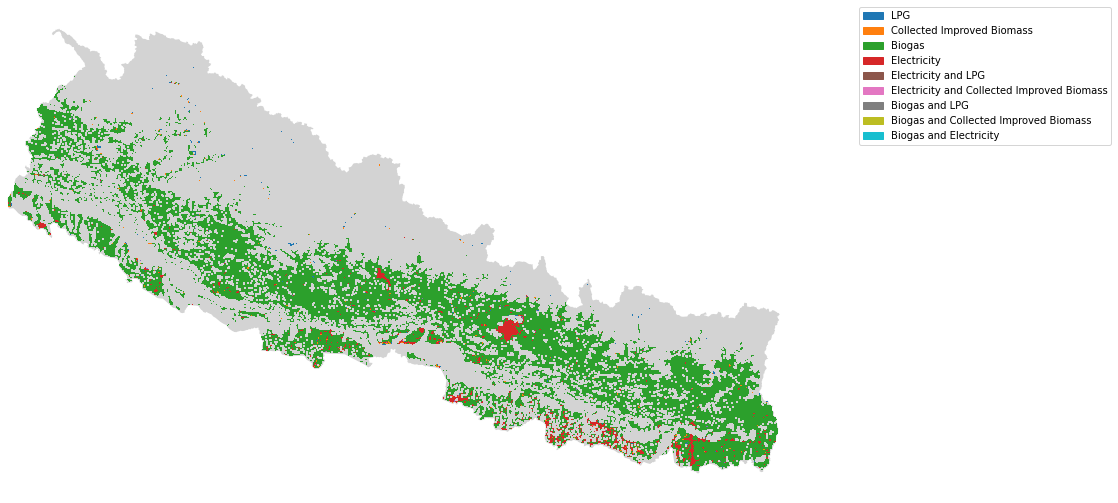

In [43]:
nepal.plot('max_benefit_tech', cmap='tab10')

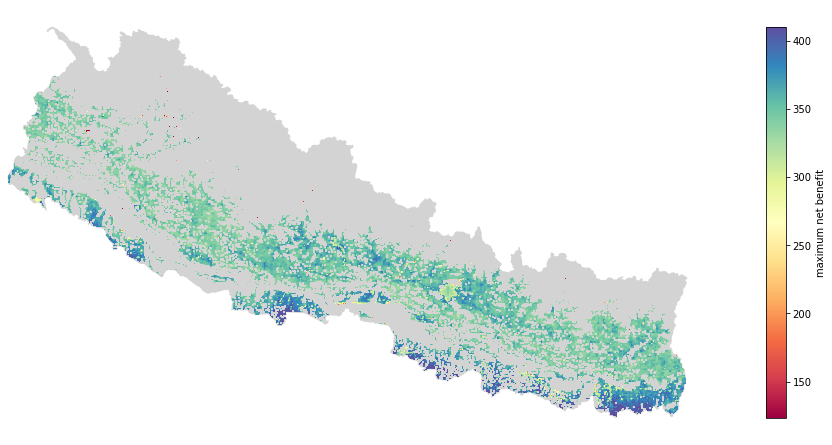

In [48]:
nepal.plot('maximum_net_benefit', cmap='Spectral', cumulative_count=[0.02, 0.98])

In [45]:
nepal.to_image('maximum_net_benefit', cmap='Spectral', cumulative_count=[0.01, 0.99])

In [46]:
nepal.to_image('max_benefit_tech', cmap='tab10', legend_position=(0.7, 0.9))

In [49]:
nepal.gdf.to_csv(os.path.join(output_directory, 'Output', 'results.csv'))

In [50]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

Execution time: 1 min 15 sec


In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, to_rgba
red = to_rgba('#FF5733', alpha=None)
clist = [[0.3, 0.5, 0.7, 1], [0, 0.5, 0.7, 1], red]
cmap = ListedColormap(clist)
cmap

In [ ]:
dff = nepal.gdf.groupby(['max_benefit_tech']).agg({'Calibrated_pop': lambda row: np.nansum(row) / 1000000,
                                                   'maximum_net_benefit': lambda row: np.nansum(row) / 1000000,
                                                   'investment_costs': lambda row: np.nansum(row) / 1000000}).reset_index()

In [ ]:
fig = px.pie(dff, names='max_benefit_tech', values='Calibrated_pop', color_discrete_sequence=['#dc0f0f', '#a86ee1', '#79de13'])
fig.write_image(os.path.join(output_directory, 'output', 'Pop_per_tech.pdf'), width=500, height=500)
fig.update_traces(textfont_size=16)
fig.show()

In [ ]:
fig = px.pie(dff, names='max_benefit_tech', values='investment_costs', color_discrete_sequence=['#dc0f0f', '#a86ee1', '#79de13'])
fig.write_image(os.path.join(output_directory, 'output', 'Investments.pdf'), width=500, height=500)
fig.update_traces(textfont_size=16)
fig.show()